In [1]:
#@Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from retry import retry

from language_models.ollama_logits import OllamaLanguageModel

# from components.components import compute_desire_for_gamble

In [2]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3:70b", system_message=system_message, streaming=False
)

In [3]:
@retry(ValueError, tries=5)
def compute_desire_for_gamble(model: OllamaLanguageModel, object: str, query_tokens: list):
    """compute value."""
    request = (
        f"You are very logical and rational when doing this task. "
        f"You are presented with a gamble. it has a probability of winning, a value of winning, and a value of losing. "
        f"If you win, you get the win value, if you lose, you get loss value. "
        f"The probability of winning is the 'win_probability'. "
        f"You need to think about an option, and how desirable it is. "
        f"Compute the expected value of the gamble first. "
        f"Think about how good or bad it is and provide a affective feeling preference value between 1 and 10 "
        f"which corresponds to the desirability of the option. "
        f"Use 1 for very good and 10 for very bad. "
        f"The option is: {object}"
        f"Provide this answer in the form of a number between 1 and 10. "
        f"Provide only a single number as the response."
        f"Do not provide any explanations, just provide a single number."
    )

    output, logits = model.sample_text(request, logits = True, query_tokens=query_tokens)
    return output, logits

In [4]:
@retry(ValueError, tries=5)
def compute_generic_attitude(model: OllamaLanguageModel, object: str, query_tokens: list):
  """Compute attitude for a specific set of objects."""
  request = (
    f"You need to think about an option, and how desirable it is. "
    f"Think about how good or bad it is and provide a affective feeling preference value between 1 and 10 "
    f"which corresponds to the desirability of the option. "
    f"Use 1 for very bad and 10 for very good. "
    f"The option is: {object}"
    f"Provide this answer in the form of a number between 1 and 10. "
    f"Provide only a single number as the response."
    f"Do not provide any explanations, just provide a single number."
  )

  llm_value, logits = model.sample_text(request, logits = True, query_tokens=query_tokens)

  return llm_value, logits

llm_value, logits = compute_generic_attitude(
  model, "Getting a puppy, but having to live in a small apartment.\n", query_tokens = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
)

print(f"Output: {llm_value}. Logits: {logits}")

Output: 6. Logits: {'1': 0, '3': 7.202722862587052e-10, '4': 1.0284314839736908e-06, '5': 3.1244031561072916e-05, '6': 0.6306742429733276, '7': 0.36932572722435, '8': 0.00417734682559967, '9': 1.1723446213807165e-08}


In [5]:
NUM_ITER = 200

gvs = []
bvs = []
pws = []
expected_values = []
attitudes = []
all_logits = []
query_tokens = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
for i in range(NUM_ITER):
  # Simulate decision making for each player.
  Good_value = np.random.choice(np.arange(10))
  Bad_value = np.random.choice(np.arange(10))
  P_w = np.random.choice(np.arange(10) / 10)

  # Compute the expected value of the gamble.
  expected_value = P_w * Good_value + (1 - P_w) * -1*Bad_value
  gamble_input = f"Probability of Winning (P_w): {P_w}, Positive Value on Win (G): {Good_value}, Negative Value on Loss (B): {-Bad_value}"
  # Compute affective LLM value estimate
  llm_value, logits = compute_desire_for_gamble(model, gamble_input, query_tokens=query_tokens)

  for j in range(10):
    if str(j+1) not in logits.keys():
      logits[str(j+1)] = 0

  all_logits.append(logits)
  expected_values.append(expected_value)
  attitudes.append(llm_value)
  gvs.append(Good_value)
  bvs.append(Bad_value)
  pws.append(P_w)

In [6]:


for i in range(20):
  print(f"GV: {gvs[i]}; BV: {bvs[i]}; P_w: {pws[i]}; EV: {expected_values[i]}; Attitude: {attitudes[i]}")
  # print([softmax(j) for j in all_logits[i].values()])

  print(list(all_logits[i].values()))
  print(sum(list(all_logits[i].values())))
  print("==================================================")
  print()

GV: 8; BV: 5; P_w: 0.4; EV: 0.20000000000000018; Attitude: 6
[1.4116081956672133e-06, 0.000223964307224378, 0.0011937366798520088, 0.006943062413483858, 0.003659344045445323, 0.9329647421836853, 0.06703529506921768, 0.0005688689416274428, 1.1246837857470382e-05, 0]
1.0126016720865891

GV: 4; BV: 5; P_w: 0.9; EV: 3.1; Attitude: 2
[0.0004597003571689129, 1, 0.023995108902454376, 0.00016271103231702, 4.3574200390139595e-05, 0.0002738083421718329, 1.6496400348842144e-05, 2.3932439034979325e-06, 1.0069775413512616e-07, 0]
1.0249538931765088

GV: 6; BV: 9; P_w: 0.8; EV: 3.000000000000001; Attitude: 3
[0.00027571734972298145, 0.12407025694847107, 0.31687161326408386, 0.5590580701828003, 0.05391179397702217, 0.004805815871804953, 0.007928560487926006, 0.0003222190134692937, 7.446239465025428e-07, 0]
1.0672447917192471

GV: 8; BV: 7; P_w: 0.9; EV: 6.5; Attitude: 2
[0.0015020996797829866, 0.9216541647911072, 0.07834576070308685, 0.04562488570809364, 0.0014843731187283993, 0.00026206488837487996,

In [7]:
attitude_samples = []
for i in range(NUM_ITER):
  p = list(all_logits[i].values())
  p = np.array(p) / sum(p)
  attitude_sample = np.random.choice([int(num) for num in all_logits[i].keys()], p=p, size = 100)
  attitude_samples.append(attitude_sample)

In [14]:
"""Implement basic prospect theory curves based on partial sigmoid curves."""

import numpy as np
import matplotlib.pyplot as plt

def curve_fit(expected_values: list[float], attitudes: list[float]) -> tuple[np.ndarray, np.ndarray]:
  """Fit data with expected values and attitudes towards risky gambles, and return a dictionary of"""
  gains = np.array([expected_value for expected_value, attitude in zip(expected_values, attitudes) if np.greater_equal(expected_value, 0)])
  g_attitude = np.array([attitude for expected_value, attitude in zip(expected_values, attitudes) if np.greater_equal(expected_value, 0)])
  losses = np.array([expected_value for expected_value, attitude in zip(expected_values, attitudes) if np.less(expected_value, 0)])
  l_attitude = np.array([attitude for expected_value, attitude in zip(expected_values, attitudes) if np.less(expected_value, 0)])

  from scipy.optimize import curve_fit

  def sigmoid(x, L ,x0, k, b):
      y = L / (1 + np.exp(-k*(x-x0))) + b
      return (y)

  # Fit for gains
  p0 = [max(g_attitude), np.median(gains),1,min(g_attitude)] # this is an mandatory initial guess
  popt, _ = curve_fit(sigmoid, gains, g_attitude,p0, method='dogbox', maxfev=100000)

  # Fit for losses
  q0 = [max(l_attitude), np.median(losses),1,min(l_attitude)] # this is an mandatory initial guess
  qopt, _ = curve_fit(sigmoid, losses, l_attitude,q0, method='dogbox', maxfev=100000)

  l_x = np.linspace(-10,0,100)
  g_x = np.linspace(0,10,100)


  x = np.concatenate(
     (l_x, g_x)
  )
  curve = np.concatenate(
     (sigmoid(l_x, *qopt),
     sigmoid(g_x, *popt))
  )


  return x, curve

def plot_curve(
    x: np.ndarray,
    curve: np.ndarray,
    expected_values: list[float],
    attitudes: list[float],
    title: str = "Risky Gamble Value Estimates"
) -> None:
  """Plot a prospect theory curve."""
  plt.plot(x, curve, '--k')
  plt.plot(expected_values, attitudes, 'yo')
  plt.xlabel("Expected Value")
  plt.ylabel("Affective Value")
  plt.ylim(0., 10.)
  plt.title(title)
  plt.show()

   

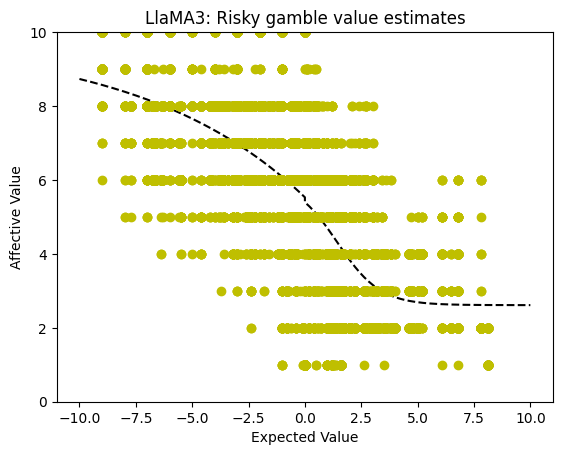

In [15]:
%autoreload 2

inputs = []
outputs = []
all_gvs = []
all_bvs = []
all_pws = []

for i in range(NUM_ITER):
  for j in range(len(attitude_samples[i])):
    inputs.append(expected_values[i])
    outputs.append(attitude_samples[i][j])
    all_gvs.append(gvs[i])
    all_bvs.append(bvs[i])
    all_pws.append(pws[i])

outcomes = curve_fit(inputs, outputs)
plot_curve(*outcomes, inputs, outputs, title = "LlaMA3: Risky gamble value estimates")

In [10]:
import csv

with open('./llama3-70b-risky-neg.csv', 'w') as f:

  writer = csv.writer(f)
  writer.writerow(
    ["EV", "BV", "GV", "PW", 
     "logits_1", "logits_2", "logits_3", "logits_4", "logits_5", 
     "logits_6", "logits_7", "logits_8", "logits_9", "logits_10"]
  )
  for i in range(NUM_ITER):
    p = list(all_logits[i].values())
    p = np.array(p) / sum(p)
    writer.writerow(
      [expected_values[i], bvs[i], gvs[i], pws[i], *p] 
    )

In [11]:
# For every gamble in range(NUM_ITER):
for i in range(NUM_ITER):
  print(all_logits[i].values())


dict_values([1.4116081956672133e-06, 0.000223964307224378, 0.0011937366798520088, 0.006943062413483858, 0.003659344045445323, 0.9329647421836853, 0.06703529506921768, 0.0005688689416274428, 1.1246837857470382e-05, 0])
dict_values([0.0004597003571689129, 1, 0.023995108902454376, 0.00016271103231702, 4.3574200390139595e-05, 0.0002738083421718329, 1.6496400348842144e-05, 2.3932439034979325e-06, 1.0069775413512616e-07, 0])
dict_values([0.00027571734972298145, 0.12407025694847107, 0.31687161326408386, 0.5590580701828003, 0.05391179397702217, 0.004805815871804953, 0.007928560487926006, 0.0003222190134692937, 7.446239465025428e-07, 0])
dict_values([0.0015020996797829866, 0.9216541647911072, 0.07834576070308685, 0.04562488570809364, 0.0014843731187283993, 0.00026206488837487996, 1.0824011269505718e-06, 1.507153228885727e-07, 9.220426733236309e-08, 0])
dict_values([0.0005635217530652881, 0.3597587049007416, 0.12522317469120026, 0.5150180459022522, 0.0038560586981475353, 2.883125671360176e-05, 1